# QAOA for MaxCut
The Quantum Approximate Optimization Algorithm for solving the Max-Cut Problem.

## The Max-Cut Problem
Consider a graph with $m$ edges and $n$ vertices. We seek the partition 
$z$
 of the vertices into two sets 
$A$
 and 
$B$
 which maximizes

 $$C(z)=\sum^{m}_{\alpha=1} C_{\alpha}(z)$$


where 
$C$ counts the number of edges cut. 
$C_{\alpha}(z)=1$
 if 
$z$
 places one vertex from the 
$α^{th}$
 edge in set 
$A$
 and the other in set 
$B$
, and 
$C_{\alpha}(z)=0$
 otherwise. Finding a cut which yields the maximum possible value of 
$C$
 is an NP-complete problem, so our best hope for a polynomial-time algorithm lies in an approximate optimization. In the case of MaxCut, this means finding a partition 
$z$
 which yields a value for 
$C(z)$
 that is close to the maximum possible value.


We can represent the assignment of vertices to set 
$A$
 or 
$B$
 using a bitstring, 
$z=z_1...z_n$
 where 
$z_i=0$
 if the 
$i^{th}$
 vertex is in 
$A$
 and 
$z_i=1$
 if it is in 
$B$
. 

## A circuit for QAOA

This section describes implementing a circuit for QAOA using basic unitary gates to find approximate solutions to the MaxCut problem. Firstly, denoting the partitions using computational basis states 
$|
z
⟩$
, we can represent the terms in the objective function as operators acting on these states

$$C_{\alpha}=\frac{1}{2}(1−\sigma_{z}^{j} \sigma_{z}^{k})$$


where the $\alpha^{th}$
 edge is between vertices  $(j,k)$.

$C_{\alpha}$ has eigenvalue 1 if and only if the $j^{th}$ and $k^{th}$
 qubits have different z-axis measurement values, representing separate partitions. The objective function 
C
 can be considered a diagonal operator with integer eigenvalues


# Implementing QAOA in PennyLane

## Imports and Setup

In [3]:
import pennylane as qml
from pennylane import numpy as np

np.random.seed(135)

## Operators

We specify the number of qubits (vertices) with n_wires and compose the unitary operators using the definitions above. 
$U_B$
 operators act on individual wires, while 
$U_C$
 operators act on wires whose corresponding vertices are joined by an edge in the graph. We also define the graph using the list graph, which contains the tuples of vertices defining each edge in the graph

In [5]:
n_wires = 4
graph = [(0, 1), (0, 3), (1, 2), (2, 3)]

# unitary operator U_B with parameter beta
def U_B(beta):
    for wire in range(n_wires):
        qml.RX(2 * beta, wires=wire)


# unitary operator U_C with parameter gamma
def U_C(gamma):
    for edge in graph:
        wire1 = edge[0]
        wire2 = edge[1]
        qml.CNOT(wires=[wire1, wire2])
        qml.RZ(gamma, wires=wire2)
        qml.CNOT(wires=[wire1, wire2])

We will need a way to sample a measurement of multiple qubits in the computational basis, so we define a Hermitian operator to do this. The eigenvalues of the operator are the qubit measurement values in integer form.

In [6]:
def comp_basis_measurement(wires):
    n_wires = len(wires)
    return qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)

## Circuit
Next, we create a quantum device with 4 qubits.

In [7]:
dev = qml.device("default.qubit", wires=n_wires, analytic=True, shots=1)

We also require a quantum node which will apply the operators according to the angle parameters, and return the expectation value of the observable 

$\sigma^{j}_{z} \sigma^{k}_{z}$
 to be used in each term of the objective function later on. The argument edge specifies the chosen edge term in the objective function, 
$(
j
,
k
)$
. Once optimized, the same quantum node can be used for sampling an approximately optimal bitstring if executed with the edge keyword set to None. Additionally, we specify the number of layers (repeated applications of 
$U
_B
U
_C$
) using the keyword n_layers.



In [8]:
pauli_z = [[1, 0], [0, -1]]
pauli_z_2 = np.kron(pauli_z, pauli_z)


@qml.qnode(dev)
def circuit(gammas, betas, edge=None, n_layers=1):
    # apply Hadamards to get the n qubit |+> state
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    # p instances of unitary operators
    for i in range(n_layers):
        U_C(gammas[i])
        U_B(betas[i])
    if edge is None:
        # measurement phase
        return qml.sample(comp_basis_measurement(range(n_wires)))
    # during the optimization phase we are evaluating a term
    # in the objective using expval
    return qml.expval(qml.Hermitian(pauli_z_2, wires=edge))

## Optimization



In [9]:
def qaoa_maxcut(n_layers=1):
    print("\np={:d}".format(n_layers))

    # initialize the parameters near zero
    init_params = 0.01 * np.random.rand(2, 2)

    # minimize the negative of the objective function
    def objective(params):
        gammas = params[0]
        betas = params[1]
        neg_obj = 0
        for edge in graph:
            # objective for the MaxCut problem
            neg_obj -= 0.5 * (1 - circuit(gammas, betas, edge=edge, n_layers=n_layers))
        return neg_obj

    # initialize optimizer: Adagrad works well empirically
    opt = qml.AdagradOptimizer(stepsize=0.5)

    # optimize parameters in objective
    params = init_params
    steps = 30
    for i in range(steps):
        params = opt.step(objective, params)
        if (i + 1) % 5 == 0:
            print("Objective after step {:5d}: {: .7f}".format(i + 1, -objective(params)))

    # sample measured bitstrings 100 times
    bit_strings = []
    n_samples = 100
    for i in range(0, n_samples):
        bit_strings.append(int(circuit(params[0], params[1], edge=None, n_layers=n_layers)))

    # print optimal parameters and most frequently sampled bitstring
    counts = np.bincount(np.array(bit_strings))
    most_freq_bit_string = np.argmax(counts)
    print("Optimized (gamma, beta) vectors:\n{}".format(params[:, :n_layers]))
    print("Most frequently sampled bit string is: {:04b}".format(most_freq_bit_string))

    return -objective(params), bit_strings


# perform qaoa on our graph with p=1,2 and
# keep the bitstring sample lists
bitstrings1 = qaoa_maxcut(n_layers=1)[1]
bitstrings2 = qaoa_maxcut(n_layers=2)[1]


p=1
Objective after step     5:  2.7867521
Objective after step    10:  2.9984850
Objective after step    15:  2.9999902
Objective after step    20:  2.9999999
Objective after step    25:  3.0000000
Objective after step    30:  3.0000000
Optimized (gamma, beta) vectors:
[[-0.78539816]
 [-1.17809782]]
Most frequently sampled bit string is: 1010

p=2
Objective after step     5:  2.3554196
Objective after step    10:  3.3328592
Objective after step    15:  3.8699256
Objective after step    20:  3.9893538
Objective after step    25:  3.9993536
Objective after step    30:  3.9999635
Optimized (gamma, beta) vectors:
[[ 1.56715833 -0.78313748]
 [-1.17674955 -0.78574624]]
Most frequently sampled bit string is: 0101


## Plotting the Results

We can plot the distribution of measurements obtained from the optimized circuits. As expected for this graph, the partitions 0101 and 1010 are measured with the highest frequencies, and in the case where we set n_layers=2 we obtain one of the optimal partitions with 100% certainty.

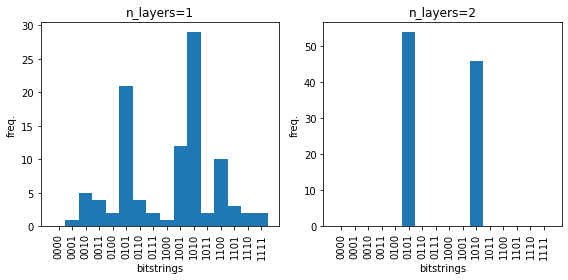

In [10]:
import matplotlib.pyplot as plt

xticks = range(0, 16)
xtick_labels = list(map(lambda x: format(x, "04b"), xticks))
bins = np.arange(0, 17) - 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("n_layers=1")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings1, bins=bins)
plt.subplot(1, 2, 2)
plt.title("n_layers=2")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings2, bins=bins)
plt.tight_layout()
plt.show()